## <a id=99>Описание датасета</a>

[К датасету](#1)


---

## <center><a id=0 style='color:red'>Импорт библиотек</a>


In [23]:
from ds_nms.funcs import *
from ds_nms.optimize import *

In [24]:
import pandas as pd
from scipy.stats import kstest, kruskal
import plotly.express as px
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Any, Dict
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_validate,
    StratifiedGroupKFold,
    StratifiedKFold,
)
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
)
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    QuantileTransformer,
    Normalizer,
    MinMaxScaler,
    PowerTransformer,
    PolynomialFeatures,
    OrdinalEncoder,
    TargetEncoder,
)
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    RandomForestRegressor,
    HistGradientBoostingRegressor,
    IsolationForest,
    GradientBoostingRegressor,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

In [25]:
np.set_printoptions(suppress=True, precision=2)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

---

## <center><a id=1 style='color:red'>Импорт датасета</a>

[К описанию](#99)


In [26]:
df = pd.read_excel(io='data/Data_7.xlsx', header=2)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)

df.index.freq = 'MS'
display(df.head(3))
df.shape

,year,month,val_metro,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
date,,,,,,,,,,
2016-01-01,2016,1,7687405,0.664580,1.122006e+06,12179000,0.919547,0.0482,0.0723,1.050002e+06
2016-02-01,2016,2,7928317,0.645410,1.168815e+06,12179000,0.957532,0.0482,0.0723,9.911876e+05
2016-03-01,2016,3,8228019,0.643148,1.214508e+06,12179000,0.982312,0.0482,0.0723,1.128213e+06


(106, 10)

In [27]:
df_test = pd.read_excel(io='data/Data_9.1.xlsx', header=2)
df_test['date'] = pd.to_datetime(df_test[['year', 'month']].assign(day=1))
df_test.set_index('date', inplace=True)

df_test.index.freq = 'MS'
display(df_test.head(3))
df_test.shape

,year,month,val_metro,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
date,,,,,,,,,,
2024-11-01,2024,11,NaN,0.645995,1.750632e+06,13150000,1.019619,0.0645,0.1828,2.263888e+06
2024-12-01,2024,12,NaN,0.640792,1.829924e+06,13150000,1.031504,0.0645,0.1828,2.344510e+06
2025-01-01,2025,1,NaN,0.658882,1.670500e+06,13150000,0.919547,0.0645,0.1828,2.541762e+06


(134, 10)

In [28]:
(df.isna()).any(), (df_test.isna()).any()

(year           False
 month          False
 val_metro      False
 %_ot           False
 n_taxi_сar     False
 p_rosstat      False
 k              False
 remote_work    False
 hybrid         False
 tourism        False
 dtype: bool,
 year           False
 month          False
 val_metro       True
 %_ot           False
 n_taxi_сar     False
 p_rosstat      False
 k              False
 remote_work    False
 hybrid         False
 tourism        False
 dtype: bool)

In [29]:
(df.min().values < 0).any(), (df_test.min().values < 0).any()

(False, False)

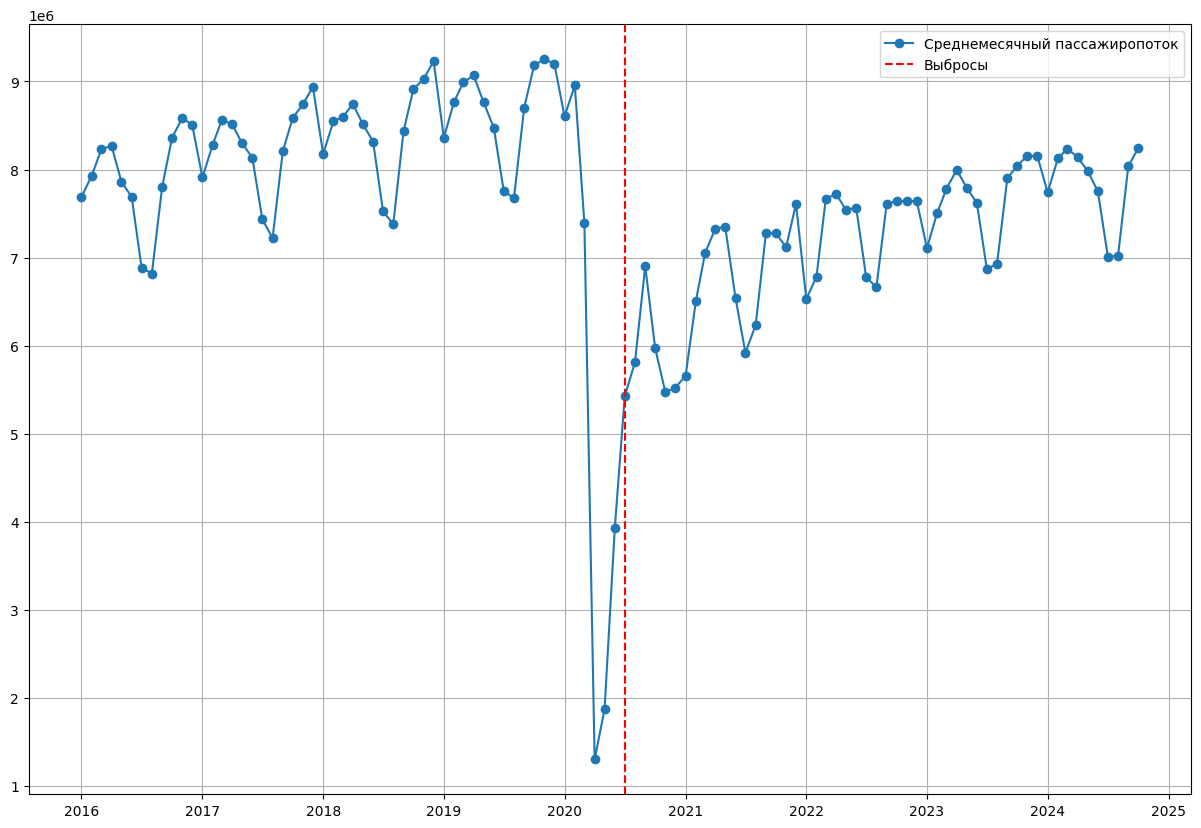

In [30]:
plt.figure(figsize=(15,10))
plt.plot(df.index, df['val_metro'], label='Среднемесячный пассажиропоток', marker='o')
plt.axvline(x=df.index[54],linestyle='--', color='r', label="Выбросы")
plt.legend()
plt.grid()

---

## <center><a id=3 style='color:red'>Разделение на обучающую и тестовую выборки</a>


In [31]:
train_data = df
test_data = df_test

y_train = train_data['val_metro']

X_train = train_data.iloc[:, 3:]
X_test = test_data.iloc[:, 3:]

X_train.shape, y_train.shape, X_test.shape,

((106, 7), (106,), (134, 7))

---

## <center><a id=2 style='color:red'>Разделение на категориальные и числовые признаки</a>


In [32]:
categorical_columns, numerical_columns = features_separate(df=df, threshold=0)
numerical_columns.remove("val_metro")
numerical_columns.remove("year")
numerical_columns.remove("month")

print(f"Категориальные признаки: {categorical_columns}")
print(f"Числовые признаки: {numerical_columns}")

Категориальные признаки: []
Числовые признаки: ['%_ot', 'n_taxi_сar', 'p_rosstat', 'k', 'remote_work', 'hybrid', 'tourism']


---

## <center><a id=3 style='color:red'>Преобразование числовых признаков</a>


### <a id=5>Относительные признаки Target 1</a>


In [33]:
X_train.sample(1)

,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
date,,,,,,,
2024-10-01,0.64314,1717925.66,13150000,1.0,0.0645,0.1828,2.186039e+06


In [34]:
X_test.sample(1)

,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
date,,,,,,,
2028-06-01,0.671187,1731015.42,13150000,0.933508,0.0645,0.1828,3.680044e+06


---

### <a id=5>Стандартизация Target 1</a>


In [35]:
X_train_std_1, X_test_std_1, scaler = df_scaling(
    X_train, X_test, numerical_columns=numerical_columns,
    scaler=StandardScaler(),
    return_scaler=True
)

(106, 7) (134, 7)


,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
count,106.0,106.0,106.0,106.0,106.0,106.0,106.0
mean,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-5.2,-2.6,-1.5,-2.0,-0.5,-1.0,-2.8
25%,-0.2,-1.0,-0.5,-0.4,-0.5,-1.0,-0.7
50%,0.3,0.1,-0.1,0.1,-0.4,0.5,0.2
75%,0.6,1.0,1.0,0.6,0.5,1.3,0.6
max,1.3,1.7,1.4,1.4,6.1,1.3,2.0


,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
count,134.0,134.0,134.0,134.0,134.0,134.0,134.0
mean,1.2,0.9,1.4,0.0,-0.4,0.5,4.2
std,0.4,0.2,0.0,1.0,0.0,0.0,1.7
min,-0.0,0.7,1.4,-2.0,-0.4,0.5,0.9
25%,0.8,0.8,1.4,-0.3,-0.4,0.5,2.8
50%,1.3,1.0,1.4,0.1,-0.4,0.5,4.5
75%,1.5,1.0,1.4,0.9,-0.4,0.5,5.6
max,1.7,1.3,1.4,1.4,-0.4,0.5,7.4


In [36]:
import joblib

joblib.dump(scaler, 'data/scalers/scaler_Data7_9_std')

['data/scalers/scaler_Data7_9_std']

---

## <center><a id=3 style='color:red'>Сохранение данных</a>


---

---


In [37]:
DIR = "train/"
FILE_DICT = {
    "X_train_1": X_train,
    "target_train_1": y_train,
}

save_data(FILE_DICT, DIR)

Файл data/train/X_train_1.pkl записан
Файл data/train/target_train_1.pkl записан


In [38]:
DIR = "test/"
FILE_DICT = {
    "X_test_1": X_test,
}

save_data(FILE_DICT, DIR)

Файл data/test/X_test_1.pkl записан


---


In [39]:
DIR = "train_std/"
FILE_DICT = {
    "X_train_std_1": X_train_std_1,
    "target_train_1": y_train,
}

save_data(FILE_DICT, DIR)

Файл data/train_std/X_train_std_1.pkl записан
Файл data/train_std/target_train_1.pkl записан


In [40]:
DIR = "test_std/"
FILE_DICT = {
    "X_test_std_1": X_test_std_1,
}

save_data(FILE_DICT, DIR)

Файл data/test_std/X_test_std_1.pkl записан


---


---


---

## <center><a id=3 style='color:red'>Загрузка данных</a>


In [41]:
DIR = "train/"
FILE_LST = [
    "X_train_1",
    "target_train_1",
]

X_train_1, target_train_1 = (
    load_data(FILE_LST, DIR)
)

X_train_1.shape, target_train_1.shape

Файл data/train/X_train_1.pkl загружен
Файл data/train/target_train_1.pkl загружен


((106, 7), (106,))

In [42]:
DIR = "test/"
FILE_LST = [
    "X_test_1",
]

X_test_1 = load_data(
    FILE_LST, DIR
)

X_test_1[0].shape

Файл data/test/X_test_1.pkl загружен


(134, 7)

---


In [43]:
DIR = "train_std/"
FILE_LST = [
    "X_train_std_1",
    "target_train_1",
]

(
    X_train_std_1,
    target_train_1
) = load_data(FILE_LST, DIR)

X_train_std_1.shape, target_train_1.shape

Файл data/train_std/X_train_std_1.pkl загружен
Файл data/train_std/target_train_1.pkl загружен


((106, 7), (106,))

In [44]:
DIR = "test_std/"
FILE_LST = [
    "X_test_std_1",
]

(
    X_test_std_1
) = load_data(FILE_LST, DIR)

X_test_std_1[0].shape

Файл data/test_std/X_test_std_1.pkl загружен


(134, 7)